In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import data
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

2022-08-15 12:19:35.214781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 12:19:35.214820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [99]:
rs = data.load_fitted_results()
rs.to_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))

dsets ['emotion', 'financial_phrasebank', 'rotten_tomatoes', 'sst2', 'tweet_eval']


100%|██████████| 168/168 [00:05<00:00, 31.49it/s]


In [4]:
rs = pd.read_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))
rs.head()

,checkpoint,ngrams,subsample,all,norm,dataset,seed,layer,padding,dataset_key_text,num_features,acc_train,acc_val
0,aatmasidha/distilbert-base-uncased-finetuned-e...,1,-1,all,,emotion,1,last_hidden_state_mean,True,text,768,0.902500,0.8555
1,bert-base-uncased,1,-1,all,,emotion,1,pooler_output,True,text,768,0.536250,0.5340
2,bert-base-uncased,1,-1,all,,emotion,1,last_hidden_state_mean,True,text,768,0.709250,0.6730
3,countvectorizer,1,-1,all,,emotion,1,pooler_output,True,text,15165,0.993250,0.8880
4,distilbert-base-uncased,1,-1,all,,emotion,1,last_hidden_state_mean,True,text,768,0.687875,0.6590


# best models table

In [42]:
def rename_checkpoint(checkpoint):
        cp = checkpoint.lower()
        if '/' in cp or 'finetune' in cp:
            if 'distilbert' in cp:
                return 'distilbert-finetuned'
            else:
                return 'bert-finetuned'
        else:
            return checkpoint

def get_acc_table(r):
    r = r[['dataset', 'checkpoint', 'layer'] + ['acc_val']]
    r.checkpoint = r.checkpoint.apply(rename_checkpoint)

    # group by (dataset, checkpoint, layer)
    rg = r.groupby(['dataset', 'checkpoint', 'layer'])

    # calc max acc
    rg = rg.max()

    # make acc table (dataset x [checkpoint, layer])
    rg = rg.reset_index().pivot(index='dataset',
                                 columns=['checkpoint', 'layer'],
                                 values='acc_val')
    rg.columns = ['___'.join(s) for s in rg.columns.to_flat_index()] # flatten index to tuples
    return rg

r = rs[rs.subsample == -1]
accs = get_acc_table(r)
r1 = r[r.ngrams == 1]
accs1 = get_acc_table(r1).add_suffix('___ngrams=1')
accs = accs.join(accs1)

/accounts/projects/vision/.local/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/accounts/projects/vision/.local/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [51]:
columns = {
    'bert-finetuned___last_hidden_state_mean': 'Emb-grams (BERT finetuned)',
    'bert-finetuned___last_hidden_state_mean___ngrams=1': 'Emb-grams (BERT finetuned, Ngram size=1)',
    'countvectorizer___pooler_output': 'Bag of ngrams',
    'tfidfvectorizer___pooler_output': 'TF-IDF',
}

tab = accs[list(columns.keys())].rename(columns=columns)
tab

# rename index
tab.index = map(data.DSETS_RENAME_DICT.get, tab.index, tab.index)
tab.round(2)

,Emb-grams (BERT finetuned),"Emb-grams (BERT finetuned, Ngram size=1)",Bag of ngrams,TF-IDF
Emotion,0.90,0.87,0.89,0.89
Financial phrasebank,0.93,0.86,0.85,0.85
Rotten tomatoes,0.82,0.77,0.75,0.76
SST2,0.87,0.82,0.82,0.84
Tweet (Hate),0.72,0.72,0.74,0.72


In [53]:
def bold_extreme_values(data):
    format_string="%.2f"
    max_=True
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

tab2 = tab.apply(bold_extreme_values, axis=1)
print(tab2.to_latex(escape=False).replace('Emb-grams (BERT finetuned)', '\\textbf{Emb-grams (BERT finetuned)}'))

\begin{tabular}{lllll}
\toprule
{} & \textbf{Emb-grams (BERT finetuned)} & Emb-grams (BERT finetuned, Ngram size=1) &  Bag of ngrams & TF-IDF \\
\midrule
Emotion              &              \textbf{0.90} &                                     0.87 &           0.89 &   0.89 \\
Financial phrasebank &              \textbf{0.93} &                                     0.86 &           0.85 &   0.85 \\
Rotten tomatoes      &              \textbf{0.82} &                                     0.77 &           0.75 &   0.76 \\
SST2                 &              \textbf{0.87} &                                     0.82 &           0.82 &   0.84 \\
Tweet (Hate)         &                       0.72 &                                     0.72 &  \textbf{0.74} &   0.72 \\
\bottomrule
\end{tabular}



In [55]:
accs.columns

Index(['bert-base-uncased___last_hidden_state_mean',
       'bert-base-uncased___pooler_output',
       'bert-finetuned___last_hidden_state_mean',
       'bert-finetuned___pooler_output', 'countvectorizer___pooler_output',
       'distilbert-base-uncased___last_hidden_state_mean',
       'distilbert-finetuned___last_hidden_state_mean',
       'tfidfvectorizer___pooler_output',
       'bert-base-uncased___last_hidden_state_mean___ngrams=1',
       'bert-base-uncased___pooler_output___ngrams=1',
       'bert-finetuned___last_hidden_state_mean___ngrams=1',
       'bert-finetuned___pooler_output___ngrams=1',
       'countvectorizer___pooler_output___ngrams=1',
       'distilbert-base-uncased___last_hidden_state_mean___ngrams=1',
       'distilbert-finetuned___last_hidden_state_mean___ngrams=1',
       'tfidfvectorizer___pooler_output___ngrams=1'],
      dtype='object')

In [ ]:
r.checkpoint

# variations table

In [62]:
columns = {
    'bert-finetuned___last_hidden_state_mean': 'BERT finetuned',
    'bert-finetuned___pooler_output': 'BERT finetuned (pooler output)',
    'bert-base-uncased___last_hidden_state_mean': 'BERT',
    'bert-base-uncased___pooler_output': 'BERT (pooler output)',    
    'bert-base-uncased___last_hidden_state_mean': 'BERT',
    'distilbert-base-uncased___last_hidden_state_mean': 'DistilBERT finetuned',
    'distilbert-finetuned___last_hidden_state_mean': 'DistilBERT',
}

tab = accs[list(columns.keys())].rename(columns=columns)
tab

# rename index
tab.index = map(data.DSETS_RENAME_DICT.get, tab.index, tab.index)
tab = tab.round(3)

In [63]:
print(tab.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &  BERT finetuned &  BERT finetuned (pooler output) &   BERT &  BERT (pooler output) &  DistilBERT finetuned &  DistilBERT \\
\midrule
Emotion              &           0.895 &                           0.896 &  0.673 &                 0.586 &                 0.689 &       0.874 \\
Financial phrasebank &           0.929 &                           0.932 &  0.836 &                 0.824 &                 0.850 &       0.813 \\
Rotten tomatoes      &           0.816 &                           0.812 &  0.784 &                 0.780 &                 0.787 &       0.799 \\
SST2                 &           0.872 &                           0.877 &  0.825 &                 0.813 &                 0.817 &       0.868 \\
Tweet (Hate)         &           0.725 &                           0.715 &  0.731 &                 0.720 &                 0.726 &       0.736 \\
\bottomrule
\end{tabular}



# all curves

In [ ]:
for dset in ['financial_phrasebank', 'rotten_tomatoes', 'sst2']: # rs.dataset.unique():
    r = rs[rs.dataset == dset]

    R = 1
    C = 3
    plt.figure(figsize=(12, 5))
    # plt.figure(figsize=(8, 12))
    for i, subsample in enumerate([100, 1000, -1]):
        plt.subplot(R, C, i + 1)
        plt.title('Num train=' + str(subsample))
        d = r[r.subsample == subsample]

        curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                       key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
        curve.append(curve.pop(0)) # move BERT to bottom
        for key, group in curve:
            g = group.sort_values('ngrams')
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
            if label == 'BERT finetuned':
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2, color='black')
            else:
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1)
        plt.ylabel(f'Accuracy ({data.DSETS_RENAME_DICT.get(dset)})')
        plt.xlabel('N-gram size')
        plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'results/acc_by_ngrams_{dset}.pdf')
#     plt.show()    
    #     print(curve)

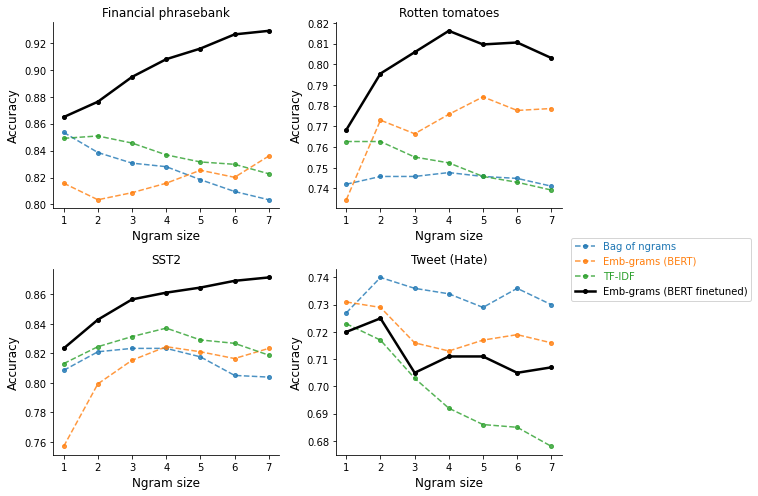

In [86]:
plt.figure(figsize=(8, 7))
for i, dset in enumerate(['financial_phrasebank', 'rotten_tomatoes', 'sst2', 'tweet_eval']):
    r = rs[rs.dataset == dset]
    r1 = r[~r.checkpoint.str.lower().str.contains('bert')]
    r2 = r[
        (r.checkpoint.apply(rename_checkpoint) == 'bert-base-uncased') & \
        (r.layer == 'last_hidden_state_mean')
    ]
    r3 = r[
        (r.checkpoint.apply(rename_checkpoint) == 'bert-finetuned') & \
        (r.layer == 'last_hidden_state_mean')
    ]    
    r = r1.append(r2).append(r3)

    plt.subplot(2, 2, i + 1)
    plt.title(f'{data.DSETS_RENAME_DICT.get(dset)}', fontsize='large')
    d = r[(r.subsample == -1)]

    curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                   key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
    curve.append(curve.pop(0)) # move BERT to bottom
    for key, group in curve:
        g = group.sort_values('ngrams')
        if 'distilbert' in key[0].lower():
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'Emb-grams (DistilBERT finetuned)')    
        else:
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'Emb-grams (BERT finetuned)')
        if 'finetuned' in label:
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2.5, color='black', ms=8)
        else:
            plt.plot(g.ngrams, g.acc_val, '.--', label=label, lw=1.5, alpha=0.8, ms=8)
    plt.ylabel(f'Accuracy', fontsize='large')
    plt.xlabel('Ngram size', fontsize='large')
#     plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                # mode="expand", borderaxespad=0, ncol=3)
plt.legend(bbox_to_anchor=(1.04, 1.0), loc="center left",
           borderaxespad=0, labelcolor='linecolor')
# plt.legend(, fontsize='large')
plt.savefig(f'results/acc_by_ngrams_full.pdf', bbox_inches='tight')
#     plt.show()    
    #     print(curve)

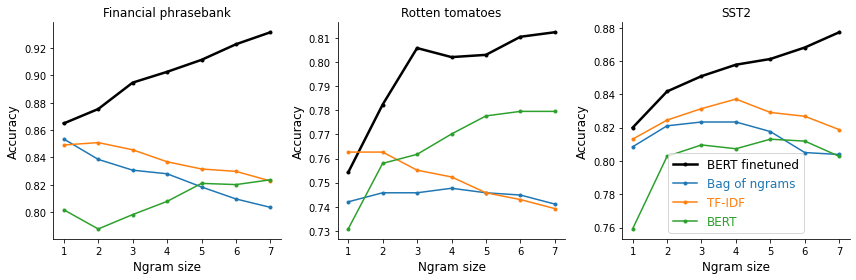

In [117]:
plt.figure(figsize=(12, 4))
for i, dset in enumerate(['financial_phrasebank', 'rotten_tomatoes', 'sst2']):
    r = rs[rs.dataset == dset]
    plt.subplot(1, 3, i + 1)
    plt.title(f'{data.DSETS_RENAME_DICT.get(dset)}', fontsize='large')
    d = r[r.subsample == subsample]

    curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                   key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
    curve.append(curve.pop(0)) # move BERT to bottom
    for key, group in curve:
        g = group.sort_values('ngrams')
        label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
        if label == 'BERT finetuned':
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2.5, color='black')
        else:
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1.5)
    plt.ylabel(f'Accuracy', fontsize='large')
    plt.xlabel('Ngram size', fontsize='large')
#     plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
plt.legend(labelcolor='linecolor', fontsize='large')
# plt.savefig(f'results/acc_by_ngrams_full.pdf')
#     plt.show()    
    #     print(curve)